# IR h5 file exploration 


This notebook aims to demonstrate the use of the h5 file containing the IR videos of the NTU-RGB-D dataset. 

In [1]:
%matplotlib notebook
import numpy as np
import h5py
import random
import os
import sys
import time

from matplotlib import animation
import matplotlib.pyplot as plt
# Moves back one folder to use module from src folder
sys.path.insert(0, os.getcwd() + '/../')

from play_skeleton import *
from src.utils.joints import *

h5_dataset_path = "/media/gnocchi/Seagate Backup Plus Drive/NTU-RGB-D/"
ir_dataset_file_name = "ir.h5"
log_file_name = "samples_names.txt"

## Randome sample

On our machine, it takes about 0.5s to fetch and decompress a given sample

In [2]:
# Sample names in a list (total of 56880 samples)
samples_names_list = [line.rstrip('\n') for line in open(h5_dataset_path + log_file_name)]

# Shuffle samples_names_list 
random.shuffle(samples_names_list)

# Take first random sample
sample_name = samples_names_list[0]

# Open dataset
ir_dataset = h5py.File(h5_dataset_path + ir_dataset_file_name, 'r')

# Get ir video shape (n_frames, 424, 512, 3) 
start = time.time()
ir_sample = ir_dataset[sample_name + "_ir"]["ir"][:]
stop = time.time()

print("It took : " + str(stop - start) + "s to fetch and decompress ir video")

It took : 0.6029822826385498s to fetch and decompress ir video


## Playback video

<IPython.core.display.Javascript object>


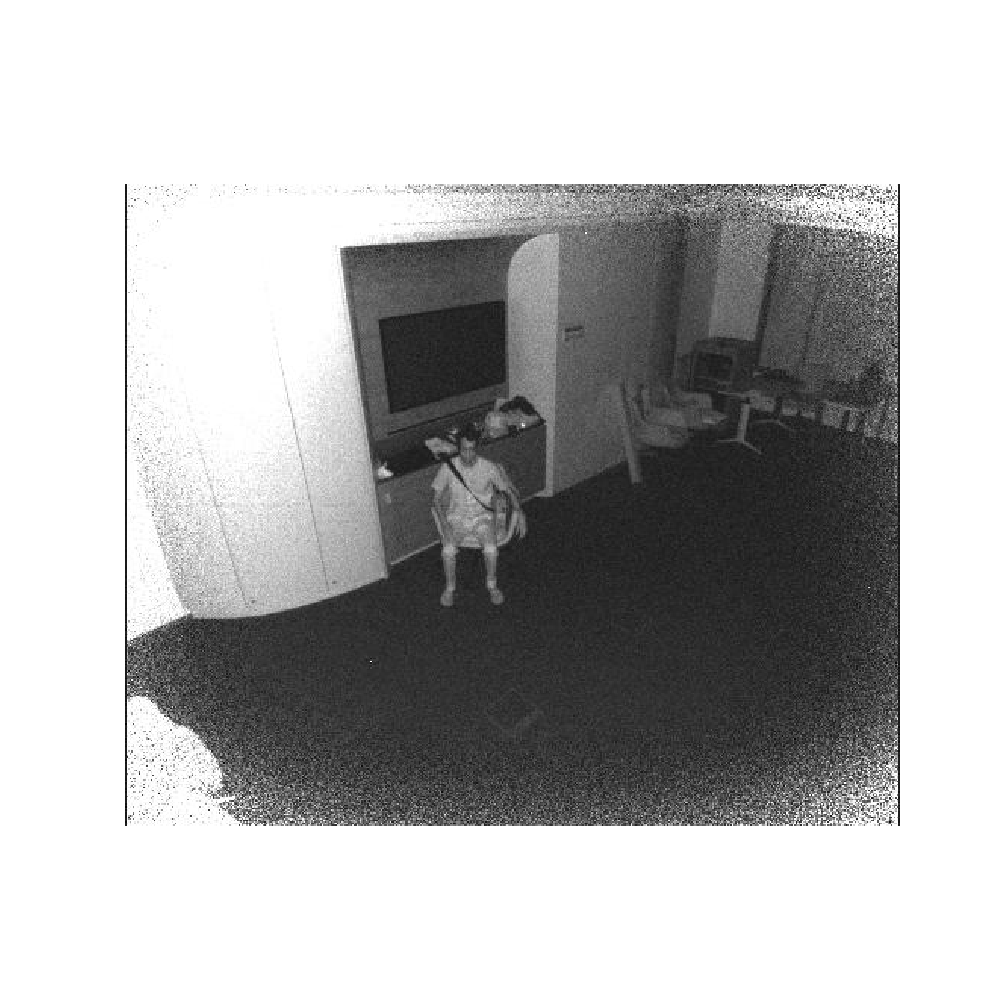

In [3]:
f = plt.figure()
ax = f.gca()
f.set_size_inches(10,10)

image = plt.imshow(ir_sample[0], interpolation='None', animated = True)

plt.axis('off')


def videoAnimation(frame_index):
    image.set_data(ir_sample[frame_index])
    
    return image,

ani = animation.FuncAnimation(f, videoAnimation, interval = 200, frames = ir_sample.shape[0], repeat = False)

## Filtering

Applying filters to remove noise and focus features

(424, 512, 3)


<IPython.core.display.Javascript object>


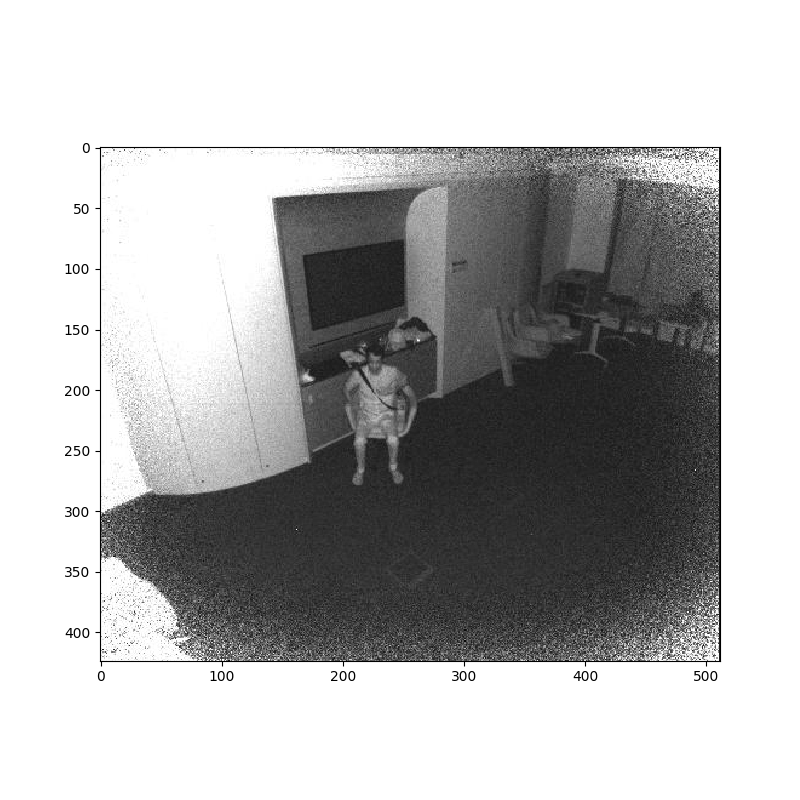

In [6]:
image = ir_sample[20]
print(image.shape)

f = plt.figure()
plt.imshow(image[:, :, 2], cmap='gray')
f.set_size_inches(8,8)

### Median filter

<IPython.core.display.Javascript object>


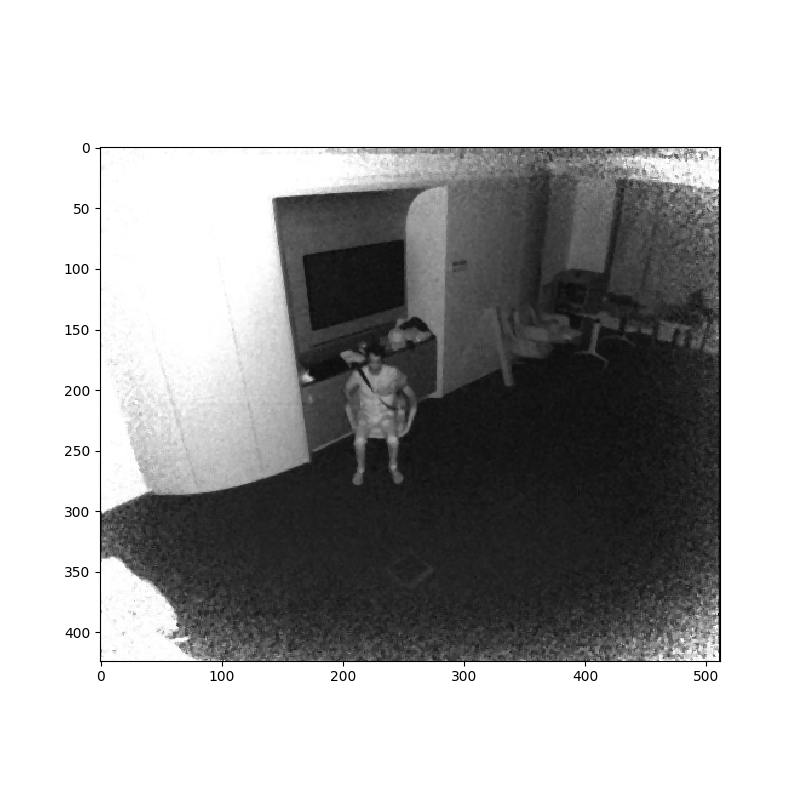

In [7]:
from scipy import ndimage

result = ndimage.median_filter(image[:, :, 0], size=3)
f = plt.figure()
plt.imshow(result, cmap='gray')
f.set_size_inches(8,8)

### Exposure

In [8]:
from skimage import exposure

<IPython.core.display.Javascript object>


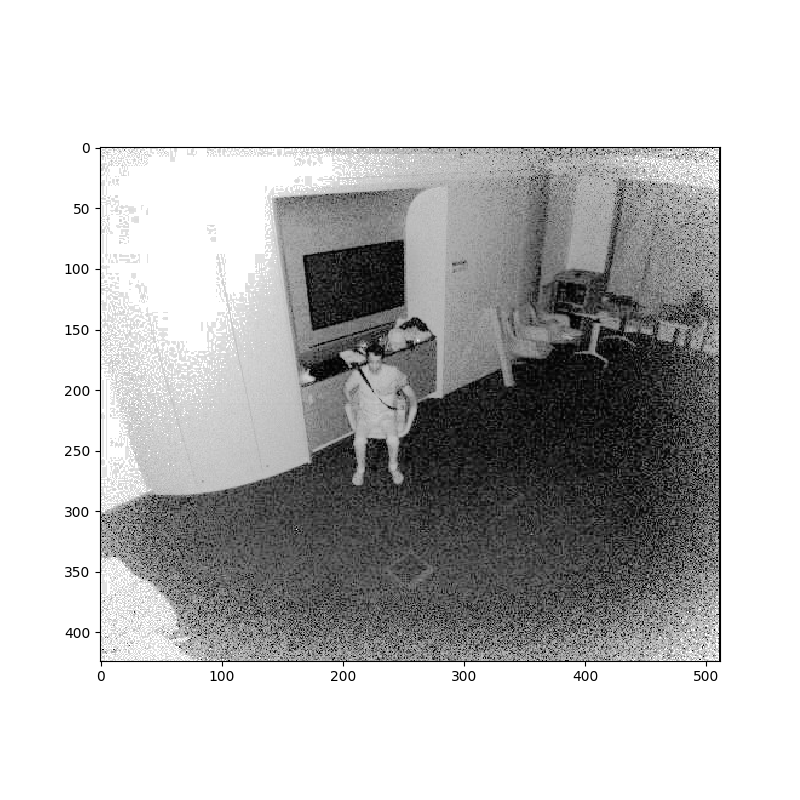

In [9]:
result = exposure.equalize_hist(image[:, :, 0])
f = plt.figure()
plt.imshow(result, cmap='gray')
f.set_size_inches(8,8)

### Cropping

In [10]:
from matplotlib.patches import Circle
from src.utils.joints import *
from skimage import feature
from scipy import ndimage as ndi


ir_skeleton_dataset_file_name = "ir_skeleton.h5"
ir_skeleton_dataset = h5py.File(h5_dataset_path + ir_skeleton_dataset_file_name, 'r')
ir_skeleton = ir_skeleton_dataset[sample_name]["ir_skeleton"][:] # shape(2 : {x, y}, seq_len, n_joints)

'''
num_frames = ir_skeleton.shape[1]

f = plt.figure()
ax = f.gca()
f.set_size_inches(10,10)
image = plt.imshow(ir_sample[0], interpolation='None', animated = True)

# skeleton_2d shape (2{xy}, max_frame, num_joint=25, 2)
right_hand_s1 = Circle((ir_skeleton[0, 0, Joints.HANDRIGHT, 0], ir_skeleton[1, 0, Joints.HANDRIGHT, 0]),5, color="red")
left_hand_s1 = Circle((ir_skeleton[0, 0, Joints.HANDLEFT, 0], ir_skeleton[1, 0, Joints.HANDLEFT, 0]),5, color="red")

ax.add_patch(right_hand_s1)
ax.add_patch(left_hand_s1)

def videoAnimation(frame_index):
    image.set_data(ir_sample[frame_index])
    
    [p.remove() for p in ax.patches]
    right_hand_s1 = Circle((ir_skeleton[0, frame_index, Joints.HANDRIGHT, 0], ir_skeleton[1, frame_index, Joints.HANDRIGHT, 0]),5, color='red')
    left_hand_s1 = Circle((ir_skeleton[0, frame_index, Joints.HANDLEFT, 0], ir_skeleton[1, frame_index, Joints.HANDLEFT, 0]),5, color='red')

    ax.add_patch(right_hand_s1)
    ax.add_patch(left_hand_s1)
    
    return image,

ani = animation.FuncAnimation(f, videoAnimation, interval = 200, frames = num_frames, repeat = False)
'''
None

<IPython.core.display.Javascript object>


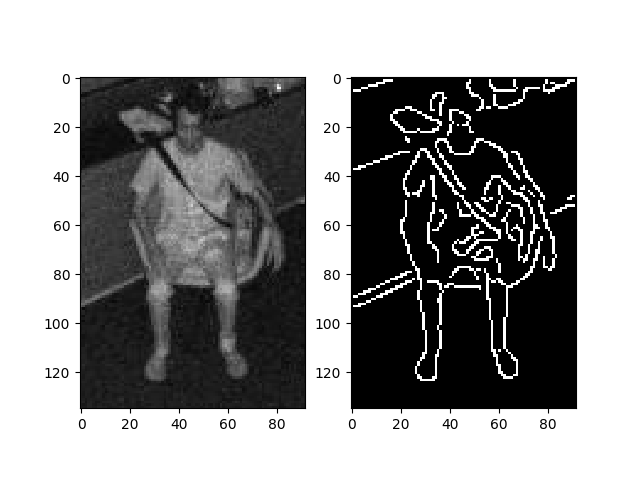

69
14.979072
19.292676


In [11]:
has_2_subjects = np.any(ir_skeleton[:, :, :, 1])

offset = 20
ir_skeleton = ir_skeleton.clip(min = 0)

if not(has_2_subjects):
    y_min = min(np.uint16(np.amin(ir_skeleton[0, :, :, 0])), ir_sample.shape[2])
    y_max = min(np.uint16(np.amax(ir_skeleton[0, :, :, 0])), ir_sample.shape[2])

    x_min = min(np.uint16(np.amin(ir_skeleton[1, :, :, 0])), ir_sample.shape[1])
    x_max = min(np.uint16(np.amax(ir_skeleton[1, :, :, 0])), ir_sample.shape[1])
    
else:
    y_min = min(np.uint16(np.amin(ir_skeleton[0, :, :, :])), ir_sample.shape[2])
    y_max = min(np.uint16(np.amax(ir_skeleton[0, :, :, :])), ir_sample.shape[2])

    x_min = min(np.uint16(np.amin(ir_skeleton[1, :, :, :])), ir_sample.shape[1])
    x_max = min(np.uint16(np.amax(ir_skeleton[1, :, :, :])), ir_sample.shape[1])

first_frame = np.pad(ir_sample[0], ((offset, offset), (offset, offset), (0, 0)), mode='constant') # shape(H + offset, W + offset, 3)
first_frame = first_frame[x_min:x_max+2*offset, y_min:y_max+2*offset, :][:, :, 0] / 255
first_frame_trans = ndi.gaussian_filter(first_frame, 3)
first_frame_trans = feature.canny(first_frame, sigma = 1.5)

f, (axs) = plt.subplots(1, 2)
original = axs[0].imshow(first_frame, cmap="gray")
transformed = axs[1].imshow(first_frame_trans, cmap="gray")

num_frames = ir_skeleton.shape[1]

def videoAnimation(frame_index):
    frame = np.pad(ir_sample[frame_index], ((offset, offset), (offset, offset), (0, 0)), mode='constant') # shape(H + offset, W + offset, 3)
    frame = frame[x_min:x_max+2*offset, y_min:y_max+2*offset, :][:, :, 0] / 255
    frame_trans = exposure.equalize_hist(frame)
    frame_trans = ndi.gaussian_filter(frame, 3)
    frame_trans = feature.canny(frame, sigma = 1.5)
    
    original.set_data(frame)
    transformed.set_data(frame_trans)
    
    return image,

ani = animation.FuncAnimation(f, videoAnimation, interval = 100, frames = num_frames, repeat = False)